In [35]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import scipy as sp
import matplotlib.pyplot as plt
import skfem as fem
from skfem.helpers import dot, grad
import numpy as np


###################################
#### Sparse approach
###################################
def theta(x_arr):
    return (x_arr>=0.5)



def fill_max_sparse_1(input_size):
    max_arr = -np.array([[1, -1], [0, 1], [0, -1]])
    iden = sp.sparse.eye(input_size)
    max_sparse = sp.sparse.bsr_matrix(max_arr)
    matrix = sp.sparse.kron(iden, max_sparse)
    # matrix = np.kron(np.eye(input_size),max_arr)
    # matrix = sp.sparse.bsr_matrix(matrix)
    return matrix.T


def fill_max_sparse_2(input_size):
    array = -sp.sparse.bsr_matrix([1, 1, -1])
    iden = sp.sparse.eye(input_size)
    matrix = np.kron(np.eye(input_size), array)
    matrix = sp.sparse.kron(iden, array)
    return matrix.T


def para_sparse_matrices(*arg):
    result = []
    for mat in zip(*arg):
        sat = sp.sparse.block_diag(mat)
        result.append(sat)
    return result


def shape_to_model(dense_matrix, activ ="relu",train=True):
    shape_list = [a.shape for a in dense_matrix]
    print(shape_list)
    for i, shap in enumerate(shape_list):
        if i == 0:
            input_mat = tf.keras.Input(shape=(int(shap[0])))
            net = layers.Dense(shap[1], activation=activ, bias_initializer='zeros', trainable=train)(input_mat)
        else:
            net = layers.Dense(shap[1], activation=activ, bias_initializer='zeros',trainable=train)(net)
    model_matrix = tf.keras.Model(input_mat, net)
    mat_init = [b for a in dense_matrix for b in [a.toarray(), np.zeros(a.shape[1])]]
    model_matrix.set_weights(mat_init)
    return model_matrix




def shape_to_random_model(dense_matrix, activ ="relu",train=True):
    shape_list = [a.shape for a in dense_matrix]
    print(shape_list)
    for i, shap in enumerate(shape_list):
        if i == 0:
            input_mat = tf.keras.Input(shape=(int(shap[0])))
            net = layers.Dense(shap[1], activation=activ, bias_initializer='zeros', trainable=train)(input_mat)
        else:
            net = layers.Dense(shap[1], activation=activ, bias_initializer='zeros',trainable=train)(net)
    model_matrix = tf.keras.Model(input_mat, net)
    # mat_init = [b for a in dense_matrix for b in [a.toarray(), np.zeros(a.shape[1])]]
    # model_matrix.set_weights(mat_init)
    return model_matrix


def set_up_max_matrix(depth):
    result = []
    while depth != 0:
        result.append(fill_max_sparse_1(depth))
        result.append(fill_max_sparse_2(depth))
        depth = int(depth / 2)
    return result



def fill_min_sparse_1(input_size):
  max_arr = np.array([[-1,1],[0,-1],[0,1]])
  iden = sp.sparse.eye(input_size)
  max_sparse = sp.sparse.bsr_matrix(max_arr)
  matrix = sp.sparse.kron(iden,max_sparse)
  return matrix.T

def fill_min_sparse_2(input_size):
  array = sp.sparse.bsr_matrix([-1,-1,1])
  iden = sp.sparse.eye(input_size)
  matrix = np.kron(np.eye(input_size), array)
  matrix = sp.sparse.kron(iden,array)
  return matrix.T

def set_up_min_matrix(depth):
  result = []
  while depth != 0:
    result.append(fill_min_sparse_1(depth))
    result.append(fill_min_sparse_2(depth))
    depth = int(depth/2)
  return result


def invert_matrix(point_list):
    ones = np.ones((point_list.shape[0],1))
    #print(ones, point_list)
    point_list = np.concatenate((point_list,ones) , axis=1)
    zeros = np.zeros((point_list.shape[0]))
    zeros[0] = 1
    solution = np.linalg.inv(point_list)@zeros
    return solution

In [36]:
point_l = np.array([[2,2],[0,2],[2,0]])
abab = invert_matrix(point_l)

print(abab)

[ 0.5  0.5 -1. ]


In [37]:
xmin=0
xmax=1


x = np.linspace(0,1,3)
grid = np.meshgrid(x,x)

X, Y = np.mgrid[xmin:xmax:3j, xmin:xmax:3j]
positions = np.vstack([X.ravel(), Y.ravel()])

positions = positions.T
dim = positions.shape[0]
ones = np.linspace(0,dim-1,dim).astype(int)

res = pd.DataFrame(positions)
#res = np.column_stack([ones.T,positions])

print(res)

     0    1
0  0.0  0.0
1  0.0  0.5
2  0.0  1.0
3  0.5  0.0
4  0.5  0.5
5  0.5  1.0
6  1.0  0.0
7  1.0  0.5
8  1.0  1.0


In [51]:
#print(res[res.index==1])
#print(1 in res.iloc[31:32,:].values)
#print(res.iloc[3].values)

#res[res.index==31]


mesh_grid = fem.MeshTri().refined(2)

print(mesh_grid.p,mesh_grid.t)

point_mesh = pd.DataFrame(mesh_grid.p).T**2
print(point_mesh.head())
simp_mesh = pd.DataFrame(mesh_grid.t).T
print(simp_mesh.head())

[[0.   1.   0.   1.   0.5  0.   0.5  1.   0.5  0.25 0.   0.75 0.75 1.
  0.   0.25 0.25 1.   0.75 0.25 0.5  0.25 0.75 0.5  0.75]
 [0.   0.   1.   1.   0.   0.5  0.5  0.5  1.   0.   0.25 0.   0.25 0.25
  0.75 0.75 1.   0.75 1.   0.25 0.25 0.5  0.5  0.75 0.75]] [[ 0  1  1  2  2  3  4  6  4  6  4  6  5  7  5  7  5  7  6  8  6  8  6  8
   9 12 11 15 14 17 19 22]
 [ 9 12 11 15 14 17 19 22  9 12 11 15 14 17 19 22 10 13 12 16 15 18 20 23
  10 13 12 16 15 18 20 23]
 [10 13 12 16 15 18 20 23 19 22 20 23 21 24 21 24 19 22 20 23 21 24 21 24
  19 22 20 23 21 24 21 24]]
      0    1
0  0.00  0.0
1  1.00  0.0
2  0.00  1.0
3  1.00  1.0
4  0.25  0.0
   0   1   2
0  0   9  10
1  1  12  13
2  1  11  12
3  2  15  16
4  2  14  15


In [40]:
#generate the general patch
def patches(positions):
    result = []
    #result = pd.DataFrame(data=a)
    #result=result.T
    for ind in range(0,dim-1):
        if not( 1 in positions.iloc[ind:ind+1,:].values):
            upper = [ind,ind+1,ind+4]
            lower = [ind,ind+3, ind+4]
            #upper.append([])
            result.append(upper)
            result.append(lower)
    return pd.DataFrame(result)

patch = patches(res)
print(patch)

   0  1  2
0  0  1  4
1  0  3  4
2  1  2  5
3  1  4  5
4  3  4  7
5  3  6  7
6  4  5  8
7  4  7  8


In [41]:
## generate the nearest neighbours

def neighbour_ind(patches, points):
    list = []
    for ind in points.index:
        obj = []
        for pat in patches.index:
            if (ind in patches.iloc[pat].values):
                obj.append(pat)
        list.append(obj)
    return pd.DataFrame(list)
pat_neighbour = neighbour_ind(simp_mesh,point_mesh)
# old:  neighbour_ind(patch,res)
print(pat_neighbour)

     0     1     2     3     4     5
0    0   NaN   NaN   NaN   NaN   NaN
1    1   2.0   NaN   NaN   NaN   NaN
2    3   4.0   NaN   NaN   NaN   NaN
3    5   NaN   NaN   NaN   NaN   NaN
4    6   8.0  10.0   NaN   NaN   NaN
5   12  14.0  16.0   NaN   NaN   NaN
6    7   9.0  11.0  18.0  20.0  22.0
7   13  15.0  17.0   NaN   NaN   NaN
8   19  21.0  23.0   NaN   NaN   NaN
9    0   8.0  24.0   NaN   NaN   NaN
10   0  16.0  24.0   NaN   NaN   NaN
11   2  10.0  26.0   NaN   NaN   NaN
12   1   2.0   9.0  18.0  25.0  26.0
13   1  17.0  25.0   NaN   NaN   NaN
14   4  12.0  28.0   NaN   NaN   NaN
15   3   4.0  11.0  20.0  27.0  28.0
16   3  19.0  27.0   NaN   NaN   NaN
17   5  13.0  29.0   NaN   NaN   NaN
18   5  21.0  29.0   NaN   NaN   NaN
19   6   8.0  14.0  16.0  24.0  30.0
20   6  10.0  18.0  22.0  26.0  30.0
21  12  14.0  20.0  22.0  28.0  30.0
22   7   9.0  15.0  17.0  25.0  31.0
23   7  11.0  19.0  23.0  27.0  31.0
24  13  15.0  21.0  23.0  29.0  31.0


In [42]:
pat_neighbour = pat_neighbour.fillna(-1)
pat_neighbour = pat_neighbour.astype(int)

print(pat_neighbour.head())

   0  1   2  3  4  5
0  0 -1  -1 -1 -1 -1
1  1  2  -1 -1 -1 -1
2  3  4  -1 -1 -1 -1
3  5 -1  -1 -1 -1 -1
4  6  8  10 -1 -1 -1


In [43]:
def neighbour_p(patches, points):
    list = []
    for ind in points.index:
        obj = []
        for pat in patches.index:
            if (ind in patches.iloc[pat].values):
                #obj.append(pat)
                loc_obj = [a for a in patches.iloc[pat].values
                       if a !=ind
                       ]
                obj.append(loc_obj)
        list.append(obj)
    return pd.DataFrame(list)
point_neighbour =  neighbour_p(simp_mesh,point_mesh)  # old: neighbour_p(patch,res)

print(point_neighbour.head())

          0         1         2     3     4     5
0   [9, 10]      None      None  None  None  None
1  [12, 13]  [11, 12]      None  None  None  None
2  [15, 16]  [14, 15]      None  None  None  None
3  [17, 18]      None      None  None  None  None
4  [19, 20]   [9, 19]  [11, 20]  None  None  None


In [44]:

def neighbour_point(patches, points):
    list = []
    for ind in points.index:
        obj = []
        for pat in patches.index:
            if ind in patches.iloc[pat].values:
                #obj.append(pat)
                loc_obj = [points.iloc[a].values.tolist() for a in patches.iloc[pat].values
                       if a!= ind
                       ]
                #loc_obj[0].append(ind)
                #print(loc_obj)
                loc_obj.insert(0,points.iloc[ind].values.tolist())
                #print(loc_obj)
                #break
                inverted = invert_matrix(np.array(loc_obj))
                # todo: insert above function here?
                obj.append(inverted)
                #print(ind)
        list.append(obj)
    return pd.DataFrame(list)
point_neighbour = neighbour_point(simp_mesh,point_mesh)
#neighbour_point(patch,res)

In [10]:
print(point_neighbour.head())

                   0                 1  \
0  [-4.0, -4.0, 1.0]              None   
1   [0.0, -4.0, 1.0]  [4.0, 0.0, -3.0]   
2   [-4.0, 0.0, 1.0]  [0.0, 4.0, -3.0]   
3   [4.0, 4.0, -7.0]              None   
4   [0.0, -4.0, 1.0]  [4.0, 0.0, -1.0]   

                                                 2     3     4     5  
0                                             None  None  None  None  
1                                             None  None  None  None  
2                                             None  None  None  None  
3                                             None  None  None  None  
4  [-3.9999999999999996, -4.0, 2.9999999999999996]  None  None  None  


In [ ]:
point_neighbour.to_csv("point_neighbour_3.csv")
res.to_csv("res_points_3.csv")

In [13]:
# For loading i guess
point_neighbour = pd.read_csv("point_neighbour_3.csv")
point_neighbour = point_neighbour.loc[:, ~point_neighbour.columns.str.contains('^Unnamed')]
res = pd.read_csv("res_points_3.csv")
res = res.loc[:, ~res.columns.str.contains('^Unnamed')]

In [45]:
#print(point_neighbour.head())

point_neighbour = point_neighbour.fillna(value=np.nan)

alt_point = point_neighbour.T.fillna(method='ffill').T
alt_point.columns = ['1','2','3','4','5','6']
#al
alt_point['7'] = alt_point['1']
alt_point['8'] = alt_point['2']
stacked = alt_point.stack().values
# print(stacked)
vec = np.array([0.5,0.5,1])
result = [aa@vec for aa in stacked]
#print(tf.convert_to_tensor(stacked))
stacked_tf = tf.stack([tf.convert_to_tensor(aa) for aa in stacked])
#print(np.array(stacked_tf))


def multiply_init(vector):
    return [row_array@vector for row_array in stacked]
#print(result)

In [46]:
#TODO: 25 -> N

def set_up_min_full():
    minimum_list = set_up_min_matrix(4)
    block_min_matrix = para_sparse_matrices(*[minimum_list for i in range(25)])
    model_minimal = shape_to_model(block_min_matrix,activ="relu", train=True)
    new_model = tf.keras.Sequential()
    new_model.add(model_minimal)
    new_model.add(layers.Dense(1))#,activation=lambda x: x
    new_model.compile()
    new_model.layers[-1].set_weights([new_df['Values'].values.reshape(25,1),np.array([0])])
    return new_model

def set_up_random_full():
    minimum_list = set_up_min_matrix(4)
    block_min_matrix = para_sparse_matrices(*[minimum_list for i in range(25)])
    model_ran = shape_to_random_model(block_min_matrix,activ="relu", train=True)
    random_model = tf.keras.Sequential()
    random_model.add(model_ran)
    random_model.add(layers.Dense(1))
    random_model.compile()
    return random_model


def shape_to_model_glob_lin(activ ="relu",train=True):
    minimum_list = set_up_min_matrix(4)
    dense_matrix = para_sparse_matrices(*[minimum_list for i in range(25)])
    shape_list = [a.shape for a in dense_matrix]
    stack_array = np.array(stacked_tf)
    print(shape_list)
    for i, shap in enumerate(shape_list):
        if i == 0:
            input_mat = tf.keras.Input(shape=(3))
            net = layers.Dense(shap[0], activation=activ, bias_initializer='zeros', trainable=train)(input_mat)
            net = layers.Dense(shap[1], activation=activ, bias_initializer='zeros',trainable=train)(net)
        else:
            net = layers.Dense(shap[1], activation=activ, bias_initializer='zeros',trainable=train)(net)
    model_matrix = tf.keras.Model(input_mat, net)
    mat_init = [b for a in dense_matrix for b in [a.toarray(), np.zeros(a.shape[1])]]
    mat_init.insert(0,np.zeros(stack_array.shape[0]))
    mat_init.insert(0,stack_array.T)
    model_matrix.set_weights(mat_init)
    new_model = tf.keras.Sequential()
    new_model.add(model_matrix)
    new_model.add(layers.Dense(1))
    new_model.compile()
    new_model.layers[-1].set_weights([new_df['Values'].values.reshape(25,1),np.array([0])])
    return new_model



def random_to_model_glob_lin(activ ="relu",train=True):
    minimum_list = set_up_min_matrix(4)
    dense_matrix = para_sparse_matrices(*[minimum_list for i in range(25)])
    shape_list = [a.shape for a in dense_matrix]
    stack_array = np.array(stacked_tf)
    print(shape_list)
    reg = tf.keras.regularizers.l1(l1=0.01)
    for i, shap in enumerate(shape_list):
        if i == 0:
            input_mat = tf.keras.Input(shape=(3))
            net = layers.Dense(shap[0], activation=activ, bias_initializer='zeros', trainable=train)(input_mat)
            net = layers.Dense(shap[1], activation=activ, bias_initializer='zeros',trainable=train,
                               kernel_regularizer=reg, bias_regularizer=reg)(net)
        else:
            net = layers.Dense(shap[1], activation=activ, bias_initializer='zeros',trainable=train,
                               kernel_regularizer=reg, bias_regularizer=reg)(net)
    model_matrix = tf.keras.Model(input_mat, net)
    new_model = tf.keras.Sequential()
    new_model.add(model_matrix)
    new_model.add(layers.Dense(1))
    new_model.compile()
    return new_model


In [19]:
min_list = set_up_min_matrix(4)

block_min = para_sparse_matrices(*[min_list for i in range(25)])


model_min = shape_to_model(block_min,activ="relu", train=True)

model_total_min = shape_to_model_glob_lin()

[(200, 300), (300, 100), (100, 150), (150, 50), (50, 75), (75, 25)]
[(200, 300), (300, 100), (100, 150), (150, 50), (50, 75), (75, 25)]


In [74]:
model_ran = shape_to_random_model(block_min,activ="relu", train=True)

[(72, 108), (108, 36), (36, 54), (54, 18), (18, 27), (27, 9)]


In [12]:
tensor_min = tf.convert_to_tensor(np.array(result).reshape((1,72)))
#tf.math.reduce_sum(model_min(tf.convert_to_tensor(np.array(result).reshape((1,81252)))))
#print(model_min(tf.convert_to_tensor(np.array(result).reshape((1,81252)))))
print(model_min(tensor_min))

NameError: name 'result' is not defined

In [90]:

#new_model(tensor_min)

In [58]:
## to do
random_model = tf.keras.Sequential()
random_model.add(model_ran)
random_model.add(layers.Dense(1))
random_model.compile()

In [48]:
 # helpers make forms look nice
@fem.BilinearForm
def a(u, v, _):
   return dot(grad(u), grad(v))
@fem.LinearForm
def L(v, w):
    x, y = w.x  # global coordinates
    f =  np.sin(np.pi * x) * np.sin(np.pi * y)#/(2*np.pi) #theta(x)*theta(y)#
    return f * v
mesh = fem.MeshTri().refined(2)
Vh = fem.Basis(mesh, fem.ElementTriP1())
D = Vh.get_dofs()
A = a.assemble(Vh)

l = L.assemble(Vh)
system = fem.condense(A, l, D=D)
x = fem.solve(*system)

In [12]:
print(x)


[0.         0.         0.         0.         0.         0.
 0.04818322 0.         0.         0.         0.         0.
 0.02445587 0.         0.         0.02445587 0.         0.
 0.         0.02372734 0.03407068 0.03407068 0.03407068 0.03407068
 0.02372734]


In [52]:
is_alpha = True

def boundary(x,y):
    return np.ones_like(x)*np.ones_like(y)#x*(1-x)*y*(1-y) #

def x_alpha(x,y,alp=0.5):
    return ((x**2+y**2)**0.5)**alp

fem_points = np.array(mesh.p)
fem_points = np.concatenate([fem_points.T,np.array(x)[:,None]],axis=1)
df_fem = pd.DataFrame(fem_points)
df_fem.columns = ['x','y','Values']
# divide by x(x-1)*y(y-1)??
# print(*zip(df_fem.x,df_fem.y))
df_fem['Values_bound'] = [boundary(a,b)  for (a,b) in zip(df_fem.x,df_fem.y) ]
if is_alpha:
    df_fem['x'] = df_fem['x']**2
    df_fem['y'] = df_fem['y']**2
    df_fem['Values'] = x_alpha(df_fem['x'],df_fem['y'])
    print(df_fem)
else:
    df_fem['Values'] = [a/b  if b!=0 else a for (a,b) in zip(df_fem['Values'],df_fem['Values_bound']) ]
res_df = point_mesh #res
res_df.columns=['x','y']
new_df = pd.merge(res_df, df_fem,
                  how='left', left_on=['x','y'], right_on = ['x','y'])
print(new_df)

         x       y    Values  Values_bound
0   0.0000  0.0000  0.000000           1.0
1   1.0000  0.0000  1.000000           1.0
2   0.0000  1.0000  1.000000           1.0
3   1.0000  1.0000  1.189207           1.0
4   0.2500  0.0000  0.500000           1.0
5   0.0000  0.2500  0.500000           1.0
6   0.2500  0.2500  0.594604           1.0
7   1.0000  0.2500  1.015272           1.0
8   0.2500  1.0000  1.015272           1.0
9   0.0625  0.0000  0.250000           1.0
10  0.0000  0.0625  0.250000           1.0
11  0.5625  0.0000  0.750000           1.0
12  0.5625  0.0625  0.752304           1.0
13  1.0000  0.0625  1.000975           1.0
14  0.0000  0.5625  0.750000           1.0
15  0.0625  0.5625  0.752304           1.0
16  0.0625  1.0000  1.000975           1.0
17  1.0000  0.5625  1.071143           1.0
18  0.5625  1.0000  1.071143           1.0
19  0.0625  0.0625  0.297302           1.0
20  0.2500  0.0625  0.507636           1.0
21  0.0625  0.2500  0.507636           1.0
22  0.5625 

In [14]:
def add_last_layer(model_add):

    new_model = tf.keras.Sequential()
    new_model.add(model_add)
    new_model.add(layers.Dense(1))#,activation=lambda x: x
    #new_model.add(Dropout(0.5))
    #new_model.add(Dense(1,activation='sigmoid'))

    new_model.compile()

    new_model.layers[-1].set_weights([new_df['Values'].values.reshape(25,1),np.array([0])])
    return new_model


<AxesSubplot:>

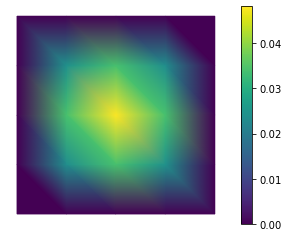

In [15]:
from skfem.visuals.matplotlib import plot, savefig

plot(mesh, x, shading='gouraud', colorbar=True)


In [303]:
def plot_decision_boundary(model_plot, steps=20, cmap='Paired'):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    cmap = plt.get_cmap(cmap)
    # steps = 1000
    x_span = np.linspace(0, 1, steps)
    print(len(x_span))
    y_span = np.linspace(0, 1, steps)
    xx, yy = np.meshgrid(x_span, y_span)
    test = np.c_[xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape[0])]
    test_list = [multiply_init(ar) for ar in test]
    print(test.shape,test_list)
    func_values = model_plot.predict(test_list)
    print(func_values.shape)
    z = func_values.reshape(xx.shape)*boundary(xx,yy)
    zz = np.sin(np.pi*xx)*np.sin(np.pi*yy)# *boundary
    ax = fig.add_subplot(projection='3d')
    ax.plot_surface(xx, yy, z, alpha=0.7)
    #ax.contourf(xx, yy, z, alpha=0.7)
    # contourf
    plt.show()
    #plot(mesh,func_values)
    return fig, ax

#plot_decision_boundary(random_model)
#plot_decision_boundary(new_model)
#plot_decision_boundary(new_model_full)

In [70]:
new_model = set_up_min_full()
#random_model = shape_to_random_model()
new_model.summary()

[(200, 300), (300, 100), (100, 150), (150, 50), (50, 75), (75, 25)]
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_10 (Functional)        (None, 25)                118825    
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 26        
Total params: 118,851
Trainable params: 118,851
Non-trainable params: 0
_________________________________________________________________


In [43]:
def train_model(model_train, N=20,train_steps=1500):
    x_len = np.linspace(0,1,N).reshape((N,1))
    xx, yy = np.meshgrid(x_len, x_len)
    z = np.sin(np.pi*xx)*np.sin(np.pi*yy)
    x_tensor = tf.convert_to_tensor(np.c_[xx.ravel(), yy.ravel()], dtype=tf.float64)
    for step in range(0,train_steps):

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x_tensor)
            ones = tf.convert_to_tensor(np.ones((x_tensor.shape[0],1)),dtype=tf.float64)
            test = tf.concat([x_tensor, ones],axis=1)
            vector_res = stacked_tf@tf.transpose(test)
            vector_res = tf.transpose(vector_res)
            tape.watch(vector_res)
            tape.watch(test)
            #break
            bounds = tf.reshape(tf.cast(boundary(x_tensor[:,0],x_tensor[:,1]), dtype=tf.float32), (x_tensor.shape[0],1))
            #print(bounds.shape)
            output = model_train(vector_res, training=True)*bounds
            z = tf.reshape(z, [-1])
            output = tf.cast(output,dtype=tf.float64)
            y_x = tape.gradient(output,x_tensor)
            loss = (tf.reduce_mean(input_tensor=(
                0.5*tf.reduce_sum(y_x, axis=1)**2 -  tf.multiply( z,output))
                ) )
            loss_direct = loss #/ tf.reduce_sum(tf.square(output))
            if step == 0:
                print(float(loss_direct))
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.00018)
        grads_d = tape.gradient(loss_direct, model_train.trainable_weights)
        optimizer.apply_gradients((grad,var) for (grad,var) in  zip(grads_d, model_train.trainable_weights)
                                  if True) # grad is not None
        if step % 50 == 0:
            print(
                "Training loss at step:",
                step, float(loss)
            )
            print("reduced loss:", float(loss_direct))
train_model(new_model,train_steps=4000)

NameError: name 'new_model' is not defined

In [59]:

new_model_full = shape_to_model_glob_lin(train=False)
#random_full = random_to_model_glob_lin()

#random_model = set_up_random_full()
new_model_full.summary()

[(200, 300), (300, 100), (100, 150), (150, 50), (50, 75), (75, 25)]
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Functional)         (None, 25)                119625    
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 26        
Total params: 119,651
Trainable params: 26
Non-trainable params: 119,625
_________________________________________________________________


50
0.2859662918746725


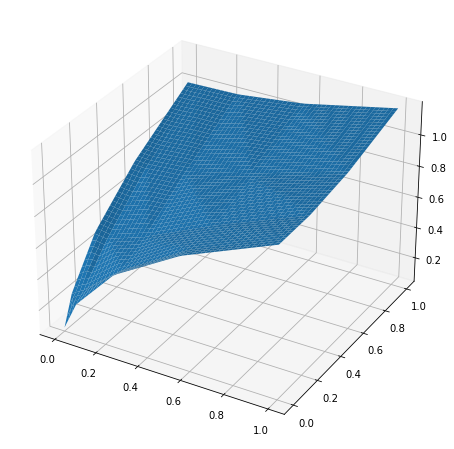

(<Figure size 2160x576 with 1 Axes>, <Axes3DSubplot:>)

<Figure size 432x288 with 0 Axes>

In [70]:
def plot_decision_boundary_full(model_plot, steps=50, cmap='Paired'):
    fig = plt.figure(figsize=(30,8))
    ax = fig.add_subplot(projection='3d')#
    x_span = np.linspace(0, 1, steps)
    print(len(x_span))
    y_span = np.linspace(0, 1, steps)
    xx, yy = np.meshgrid(x_span, y_span)
    test = np.c_[xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape[0])]
    func_values = model_plot.predict(test)
    z = func_values.reshape(xx.shape)*boundary(xx,yy)
    zz = x_alpha(xx,yy)#np.sin(np.pi*xx)*np.sin(np.pi*yy)/(2*np.pi**2)# *boundary
    #ax = fig.add_subplot(projection='3d')
    #ax.contourf(xx, yy, z-zz, alpha=0.7,cmap='autumn_r') #plt.cm.rainbow
    ax.plot_surface(xx,yy,z)
    print(np.sum((z-zz)**2)**0.5)
    #PCM=ax.get_children()[2]
    #plt.colorbar(PCM,ax=ax)
    #plt.imshow
    plt.show()
    plt.savefig('figures/2d_fullmodel_fulltrained_1000.png')
    return fig, ax

plot_decision_boundary_full(new_model_full)

In [60]:

def train_model_full(model_train, N=250,train_steps=1500):
    xerr = []
    yerr = []
    x_len = np.linspace(0,1,N).reshape((N,1))
    xx, yy = np.meshgrid(x_len, x_len)
    z_approx = x_alpha(xx,yy)

    z = np.sin(np.pi*xx)*np.sin(np.pi*yy)#/(2*np.pi) #np.array(theta(xx)*theta(yy),dtype=float)#
    z_shape = z.shape
    Num = z.size
    x_tensor = tf.convert_to_tensor(np.c_[xx.ravel(), yy.ravel()], dtype=tf.float64)
    for step in range(0,train_steps):

        with tf.GradientTape(persistent=True) as tape:
            tape.watch(x_tensor)
            ones = tf.convert_to_tensor(np.ones((x_tensor.shape[0],1)),dtype=tf.float64)
            test = tf.concat([x_tensor, ones],axis=1)
            tape.watch(test)
            bounds = tf.reshape(tf.cast(boundary(x_tensor[:,0],x_tensor[:,1]), dtype=tf.float32), (x_tensor.shape[0],1))
            output = model_train(test, training=True)*bounds
            tape.watch(bounds)
            z = tf.reshape(z, [-1])
            output = tf.cast(output,dtype=tf.float64)
            if is_alpha:
                z_approx = tf.reshape(z_approx, output.shape)
                loss = tf.reduce_sum((output-z_approx)**2)
            else:
                bord = tf.reshape(output, z_shape)
                #print(bord.shape)
                #print(bord[0,:],bord[-1,:],bord[:,0],bord[:,-1])
                bound_val = bord[0,:]**2+bord[-1,:]**2 + bord[:,0]**2+ bord[:,-1]**2
                #bound_val = tf.reduce_sum
                # print(bound_val)
                # break
                y_x = tape.gradient(output,x_tensor)
                en = tf.reshape(0.5*tf.reduce_sum(y_x**2, axis=1),shape=(Num,1))
                z = tf.reshape(z,shape=(Num,1))
                output = tf.reshape(output,shape=(Num,1))
                pot = tf.multiply(z,output)
                # the bare energy loss
                #loss = (tf.reduce_mean(input_tensor=(en-pot)))
                # with boundary conditions as loss
                #loss = loss + 2.0*output[0]**2 + 2.0*output[-1]**2
                # TODO boundary
                loss = (tf.reduce_mean(input_tensor =  en -pot  + bound_val   ))
                #print(loss)
            #print(loss)
            #break
        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
        grads_d = tape.gradient(loss, model_train.trainable_weights)
        optimizer.apply_gradients((grad,var) for (grad,var) in  zip(grads_d, model_train.trainable_weights)
                                  if True) # grad is not None
        if step % 10 == 0:
            print(
                "True L2 loss at step:",
                step, float(loss)
            )
        xerr.append(step)
        yerr.append(loss)
    return xerr,yerr

x_err_2,y_err_2 = train_model_full(new_model_full,train_steps=2000) #500?

True L2 loss at step: 0 4.469792572031259
True L2 loss at step: 10 3.4485593719362613
True L2 loss at step: 20 2.7868909610775345
True L2 loss at step: 30 2.460398946618561
True L2 loss at step: 40 2.2761468221766137
True L2 loss at step: 50 2.147339619304105
True L2 loss at step: 60 2.0649225816390637
True L2 loss at step: 70 2.012605786648469
True L2 loss at step: 80 1.9842663214264542
True L2 loss at step: 90 1.967437480998555
True L2 loss at step: 100 1.9567872375486193
True L2 loss at step: 110 1.9490638601494532
True L2 loss at step: 120 1.9434766587054138
True L2 loss at step: 130 1.9402405669047864
True L2 loss at step: 140 1.9377268049062262
True L2 loss at step: 150 1.9352301051491887
True L2 loss at step: 160 1.9328083825652187
True L2 loss at step: 170 1.9304083159447036
True L2 loss at step: 180 1.9280805549550006
True L2 loss at step: 190 1.925777732421543
True L2 loss at step: 200 1.9235440468113283
True L2 loss at step: 210 1.9213618836876631
True L2 loss at step: 220 1

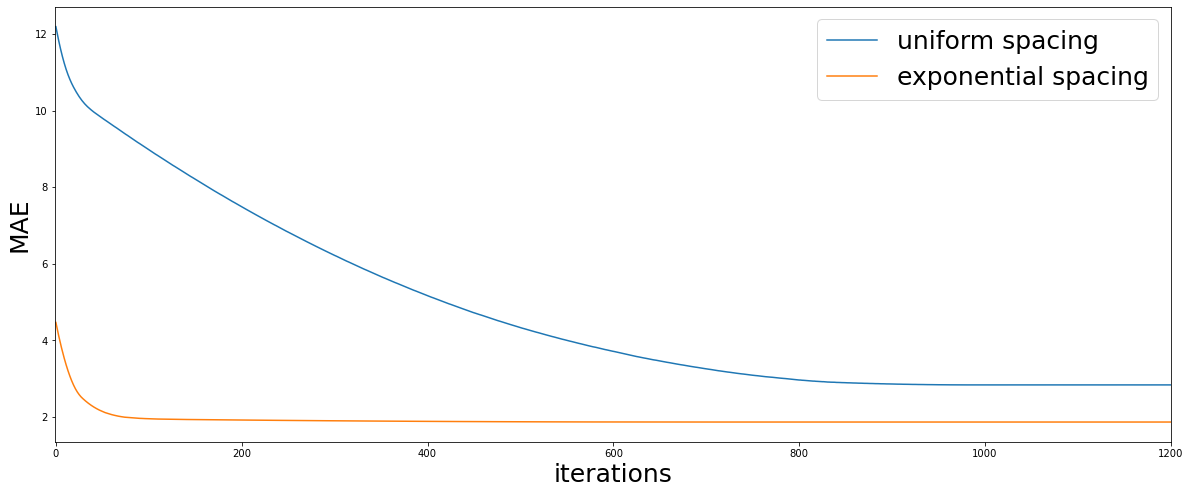

In [69]:
fig = plt.figure(figsize=(20,8))
plt.plot(x_err_1,y_err_1,label='uniform spacing')
plt.plot(x_err_2,y_err_2,label='exponential spacing')
plt.xlim(-1,1200)
#1928
plt.legend(fontsize=25)
plt.xlabel('iterations',fontsize=25)
plt.ylabel('MAE',fontsize=25)
plt.savefig('figures/xalpha_2d_full_error.png')

In [ ]:
#make as function
N=20
#model.load_weights('checkpoints/lap_energy.h5')
#model = tf.keras.models.load_model('checkpoints/lap_variational_almost.h5')
x_len = np.linspace(0,1,N).reshape((N,1))
#x_grid = np.meshgrid(x_len,x_len)
xx, yy = np.meshgrid(x_len, x_len)
z = np.sin(np.pi*xx)*np.sin(np.pi*yy)
x_tensor = tf.convert_to_tensor(np.c_[xx.ravel(), yy.ravel()], dtype=tf.float64)
start = 1

for step in range(0,2500):

# Open a GradientTape to record the operations run
# during the forward pass, which enables auto-differentiation.
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(x_tensor)
        # Create tensor that you will watch
        #test = np.c_[xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape[0])]
        ones = tf.convert_to_tensor(np.ones((x_tensor.shape[0],1)),dtype=tf.float64)
        #print(ones.shape, x_tensor.shape)
        test = tf.concat([x_tensor, ones],axis=1)
        #print(test.shape)
        #break
        #test = tf.convert_to_tensor(test)
        vector_res = stacked_tf@tf.transpose(test)
        vector_res = tf.transpose(vector_res)
        tape.watch(vector_res)
        tape.watch(test)
        #break
        bounds = tf.reshape(tf.cast(boundary(x_tensor[:,0],x_tensor[:,1]), dtype=tf.float32), (x_tensor.shape[0],1))
        #print(bounds.shape)
        output = random_model(vector_res, training=True)*bounds
        #fig = plt.figure()
        #ax = fig.add_subplot(projection='3d')
        #ax.plot_surface(xx, yy, np.array(bounds).reshape((20,20)), alpha=0.7)
        #plt.show()
        #break
        z = tf.reshape(z, [-1])
        output = tf.cast(output,dtype=tf.float64)
        #break
        y_x = tape.gradient(output,x_tensor)
        #print(output.dtype,z.dtype)
        if y_x == None:
            print('None!')
            print(output.shape)
            # reduce sum after reduce mean?
        loss = (tf.reduce_mean(input_tensor=(
            tf.square(
            0.5*tf.reduce_sum(y_x, axis=1)**2 -  tf.multiply( z,output)))
            ) )
        loss_direct = loss / tf.reduce_mean(tf.square(output)+1e-16)
        if step == 0:
            print(float(loss_direct))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.00065)
    #print('strasight train')
    grads_d = tape.gradient(loss_direct, random_model.trainable_weights)
    # Run one step of gradient descent by updating
    # the value of the variables to minimize the loss.
    optimizer.apply_gradients((grad,var) for (grad,var) in  zip(grads_d, random_model.trainable_weights)
                              if True) # grad is not None

    best_loss = 100
    # Log every 200 batches
    if step % 50 == 0:
        print(
            "Training loss at step:",
            step, float(loss)
        )

In [159]:
for layer in new_model_full.layers:
    # print(layer.get_weights())
    #print()

[array([[ 0., -2., -2., -2., -2., -2.,  0., -2., -2.,  0., -2., -2., -2.,
        -2., -2.,  0., -2., -2., -2., -2., -2., -2., -2., -2.,  2.,  0.,
        -2., -2., -2., -2.,  2.,  0.,  2.,  0.,  2., -2.,  0., -2.,  2.,
         0.,  2.,  0., -2., -2., -2., -2.,  2.,  0.,  2.,  2.,  2.,  2.,
         2.,  2.,  2.,  2.,  2.,  0.,  2.,  2.,  2.,  2.,  2.,  0.,  2.,
         0.,  0.,  0.,  0.,  0.,  2.,  0.],
       [-2.,  0.,  0.,  0.,  0.,  0., -2.,  0.,  2., -2.,  0.,  0.,  0.,
         0.,  2., -2.,  2.,  2.,  2.,  2.,  2.,  2.,  2.,  2., -2., -2.,
         0.,  0.,  0.,  0., -2., -2.,  0.,  2., -2.,  2., -2.,  0.,  0.,
         2.,  0.,  2.,  2.,  2.,  2.,  2.,  0.,  2., -2., -2., -2., -2.,
        -2., -2., -2., -2.,  0.,  2., -2., -2., -2., -2.,  0.,  2.,  0.,
         2.,  2.,  2.,  2.,  2.,  0.,  2.],
       [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  2.,  1.,  1.,  1.,
         1.,  0.,  2., -1., -1., -1., -1., -1., -1., -1., -1.,  0.,  1.,
         2.,  2.,  2.,  2.,  0.,  1

Das Taining nur für die Minima verbessert das Netzwerk nicht, selbst nach vermehrten Trainings.

- verschiedene Probleme?
- mit den selben Parametern von vorne starten
- die erste Layer auch einsetzen, und trainieren lassen!!
- 0.0004 -> 0.00027 (wasnt it :( )
- die verschiedenen Layer ändern sich!

Random Model:
- Direkt:
- Dauer: 2500 iterations

Lösungsansätze:
- mit geeigneter Randfunktion beginnen (siehe ohne!)
- nicht gegen 0 teilen!!
- initialisieren funktioniert ganz gut :)
- nur kleine \alpha für Adam 00055